# Hepatitis C Data Analysis

**Author:** Affan Ahammed

full analysis: EDA, preprocessing, KMeans clustering, PCA, visualizations, saving outputs, and a final summary.


In [22]:
# 1) Setup: install (optional) and imports
# Uncomment the pip installs if running in a fresh Colab environment
# !pip install --quiet pandas matplotlib scikit-learn seaborn scipy

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats

# Output directory
OUT_DIR = "analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42

print('Environment ready. Outputs will be saved to', OUT_DIR)

Environment ready. Outputs will be saved to analysis_outputs


## 2) Load dataset
Load CSV from the GitHub link provided in the project instructions.

In [23]:
# 2) Load dataset
GITHUB_CSV = "https://raw.githubusercontent.com/salemprakash/EDA/main/Data/HepatitisCdata.csv"
df = pd.read_csv(GITHUB_CSV)
print('Raw shape:', df.shape)
df.head()

Raw shape: (615, 14)


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## 3) Quick EDA
Show data types and missing values per column.

In [24]:
# 3) Quick EDA
print(df.info())
print('\nMissing values per column:\n', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB
None

Missing values per column:
 Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL  

## 4) Clean trivial columns
Drop fully empty columns and 'Unnamed' index cols; select numeric columns for analysis.

In [25]:
# 4) Drop empty / unnamed columns and select numeric features
df = df.dropna(axis=1, how='all')
for col in df.columns:
    if col.startswith('Unnamed'):
        df.drop(columns=[col], inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns (count):', len(numeric_cols))
numeric_cols[:30]

Numeric columns (count): 11


['Age',
 'ALB',
 'ALP',
 'ALT',
 'AST',
 'BIL',
 'CHE',
 'CHOL',
 'CREA',
 'GGT',
 'PROT']

## 5) Imputation
Impute missing numeric values using column means.

In [26]:
# 5) Mean imputation for numeric columns
imputer = SimpleImputer(strategy='mean')
df_num = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)
print('Any NaNs after imputation?', df_num.isna().sum().sum())

Any NaNs after imputation? 0


## 6) Outlier detection
Compute z-scores and report number of extreme rows (z > 4).

In [27]:
# 6) Outlier detection (z-score)
z_scores = np.abs(stats.zscore(df_num, nan_policy='omit'))
outlier_mask = (z_scores > 4).any(axis=1)
print('Number of extreme rows (z>4):', outlier_mask.sum())

Number of extreme rows (z>4): 33


## 7) Winsorization
Clip each numeric column to [1st percentile, 99th percentile] to reduce extreme outliers.

In [28]:
# 7) Winsorize/clipping
def winsorize_df(df_in):
    df_out = df_in.copy()
    for col in df_out.columns:
        lower_q = df_out[col].quantile(0.01)
        upper_q = df_out[col].quantile(0.99)
        df_out[col] = df_out[col].clip(lower_q, upper_q)
    return df_out

df_wins = winsorize_df(df_num)
df_wins.describe().T[['mean','std','min','25%','50%','75%','max']].head()

,mean,std,min,25%,50%,75%,max
Age,47.414569,9.842672,30.280,39.00,47.0,54.00,71.000
ALB,41.562482,5.317755,23.000,38.80,41.9,45.20,53.258
ALP,67.662297,20.436451,27.328,52.95,66.7,79.30,137.158
ALT,27.586740,19.187866,2.556,16.40,23.0,33.05,118.086
AST,34.077629,28.074126,14.184,21.60,25.9,32.90,187.322


## 8) Scaling
Standardize the winsorized features with StandardScaler.

In [29]:
# 8) Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_wins)
scaled_df = pd.DataFrame(X_scaled, columns=df_wins.columns)
scaled_df.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,-1.567371,-0.576366,-0.742528,-1.037266,-0.426990,-0.260457,-0.582062,-1.955898,1.740208,-0.597226,-0.596905
1,-1.567371,-0.576366,0.129174,-0.500032,-0.334303,-0.576833,1.387554,-0.519635,-0.294220,-0.516631,0.864679
2,-1.567371,1.004534,0.344650,0.449256,0.660304,-0.383492,0.305194,-0.153708,0.468691,-0.111355,1.410338
3,-1.567371,0.308185,-0.767014,0.157168,-0.409166,0.741400,-0.396250,-0.574524,0.087235,-0.097539,0.708777
4,-1.567371,-0.444625,0.315267,0.261485,-0.330738,-0.075905,0.449199,-0.958747,-0.167068,-0.187344,-0.655369


## 9) Save scaled features
Save the scaled features as CSV for reproducibility.

In [30]:
# 9) Save scaled dataframe
scaled_df.to_csv(os.path.join(OUT_DIR, 'scaled_features.csv'), index=False)
print('Saved scaled_features.csv')

Saved scaled_features.csv


## 10) Elbow and Silhouette Analysis
Compute inertia and silhouette score for k in [2..7], plot elbow and silhouette charts (inline) and save PNG.

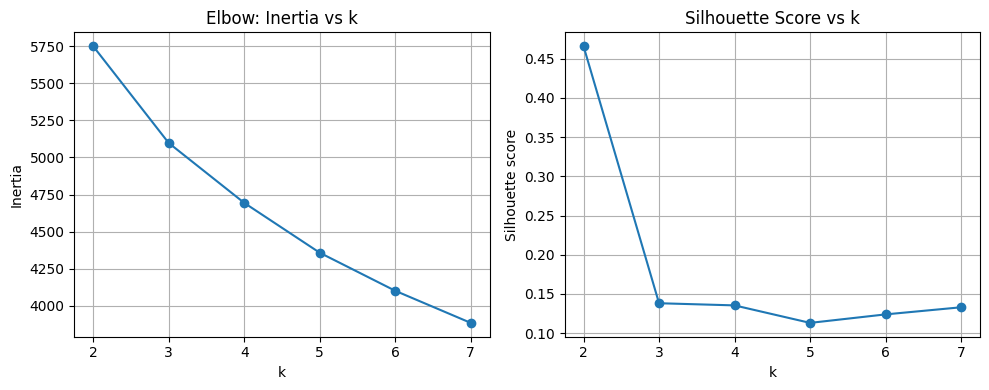

Silhouette scores: {2: 0.466, 3: 0.138, 4: 0.135, 5: 0.113, 6: 0.124, 7: 0.133}


In [31]:
# 10) Elbow + silhouette analysis
def elbow_scores(X, k_range=range(2,8)):
    inertias = []
    sil_scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
        labels_k = km.fit_predict(X)
        inertias.append(km.inertia_)
        sil_scores.append(silhouette_score(X, labels_k))
    return inertias, sil_scores

k_range = range(2,8)
inertias, sil_scores = elbow_scores(X_scaled, k_range=k_range)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(k_range), inertias, '-o')
plt.title('Elbow: Inertia vs k'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(list(k_range), sil_scores, '-o')
plt.title('Silhouette Score vs k'); plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'elbow_silhouette.png'), dpi=200)
plt.show()

print('Silhouette scores:', dict(zip(k_range, [round(s,3) for s in sil_scores])))

## 11) KMeans clustering
Choose k (3) and run KMeans with multiple inits; compute silhouette score.

In [32]:
# 11) KMeans with chosen k=3
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, n_init=50, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_scaled)
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f'Chosen k = {k_opt}, silhouette score = {sil_score:.4f}')

Chosen k = 3, silhouette score = 0.1382


## 12) Attach cluster labels
Append cluster labels to original dataframe and save CSV.

In [33]:
# 12) Append cluster labels and save
df_out = df.copy()
df_out['cluster'] = cluster_labels
# If the original has any string labels, keep them; otherwise this is fine
df_out.to_csv(os.path.join(OUT_DIR, 'data_with_clusters.csv'), index=False)
print('Saved data_with_clusters.csv')

Saved data_with_clusters.csv


## 13) Cluster profiling
Compute mean and std per cluster for numeric columns; save as CSV.

In [34]:
# 13) Cluster profiling
cluster_profile = df_out.groupby('cluster')[numeric_cols].agg(['mean','std','count']).round(3)
cluster_profile.to_csv(os.path.join(OUT_DIR, 'cluster_profile.csv'))
cluster_profile.head()

Age                   ALB                  ALP                \
           mean     std count    mean    std count    mean     std count   
cluster                                                                    
0        47.527   9.722   256  44.300  4.612   255  73.369  18.708   241   
1        53.968  12.164    31  31.874  7.280    31  90.634  75.625    29   
2        46.695   9.898   328  40.458  5.030   328  62.554  19.830   327   

            ALT  ...  CHOL    CREA                    GGT                 \
           mean  ... count    mean     std count     mean      std count   
cluster          ...                                                       
0        39.323  ...   252  83.705  14.101   256   44.917   36.651   256   
1        31.535  ...    29  93.829  84.705    31  167.332  161.182    31   
2        19.647  ...   324  78.216  61.695   328   23.252   18.500   328   

           PROT               
           mean    std count  
cluster                       
0        75.054  3.896   256  
1        68.043  8.717    30  
2        70.061  4.862   328  

[3 rows x 33 columns]

## 14) PCA
Fit PCA with 2 components for visualization and report explained variance.

In [35]:
# 14) PCA (2 components)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pcs = pca.fit_transform(X_scaled)
print('Explained variance ratio (2 components):', pca.explained_variance_ratio_, 'sum =', pca.explained_variance_ratio_.sum())

Explained variance ratio (2 components): [0.22699027 0.17640828] sum = 0.40339855399612157


## 15) PCA scatter plot
Plot PCA projected points colored by cluster; save PNG and display inline.

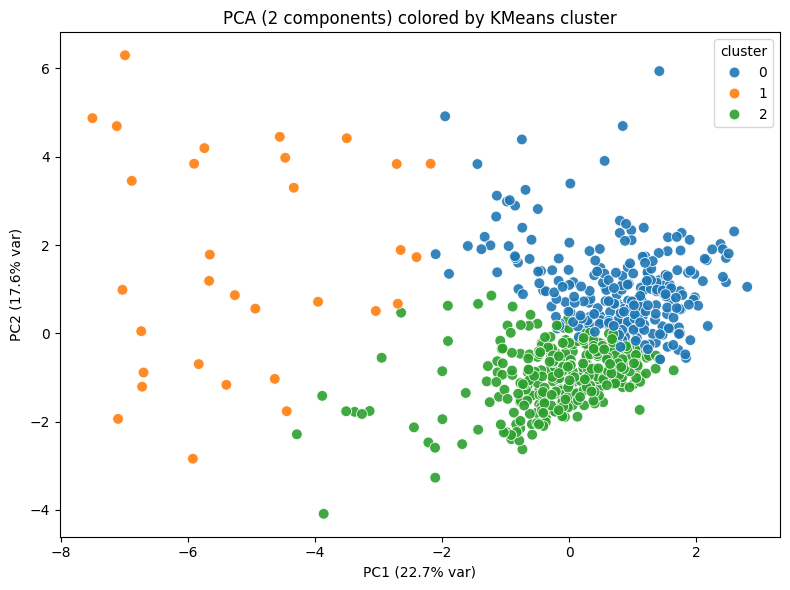

In [36]:
# 15) PCA scatter colored by cluster
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
pc_df['cluster'] = cluster_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=60, alpha=0.9)
plt.title('PCA (2 components) colored by KMeans cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)'); plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.legend(title='cluster', loc='best')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'pca_clusters.png'), dpi=200)
plt.show()

## 16) PCA with true labels (if available)
If dataset contains a ground-truth label column, visualize it for comparison.

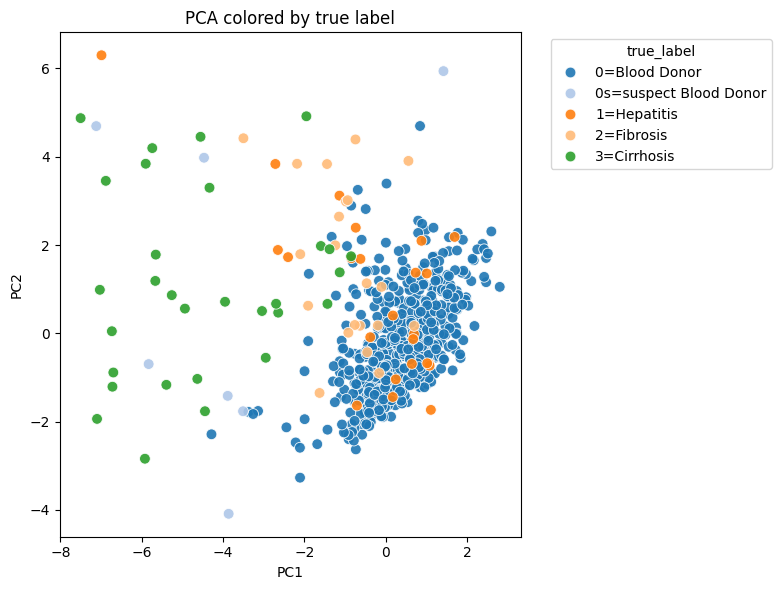

In [37]:
# 16) PCA colored by true label if present
possible_label_cols = ['Category','Class','Label','Stage']
label_col = None
for c in possible_label_cols:
    if c in df.columns:
        label_col = c
        break

if label_col:
    pc_df['true_label'] = df[label_col].values
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='true_label', palette='tab20', s=60, alpha=0.9)
    plt.title('PCA colored by true label')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.legend(title='true_label', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'pca_true_labels.png'), dpi=200)
    plt.show()
else:
    print('No common label column found. Skipping this plot.')

## 17) Summary statistics for selected features
Select a few key features (or fallback to first 3 numeric) and save means/stds per cluster.

In [38]:
# 17) Summary stats for representative features
features_of_interest = ['Bilirubin','ALT','AST']
existing = [f for f in features_of_interest if f in numeric_cols]
if len(existing) < 1:
    existing = numeric_cols[:3]
summary = df_out.groupby('cluster')[existing].agg(['mean','std','count']).round(3)
summary.to_csv(os.path.join(OUT_DIR, 'cluster_summary_selected_features.csv'))
summary

ALT                    AST              
           mean     std count     mean     std count
cluster                                             
0        39.323  28.882   256   35.161  21.554   256
1        31.535  60.530    31  131.229  79.993    31
2        19.647   7.661   327   25.379  11.665   328

## 18) Save KMeans model
Persist the trained KMeans model to disk using pickle.

In [39]:
# 18) Save KMeans model
with open(os.path.join(OUT_DIR, 'kmeans_model.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)
print('Saved kmeans_model.pkl')

Saved kmeans_model.pkl


## 19) Final metrics and cluster sizes
Print silhouette, chosen k, and sizes of each cluster.

In [40]:
# 19) Final metrics
print('FINAL METRICS')
print('Chosen k:', k_opt)
print('Silhouette score:', round(sil_score,4))
for i in range(k_opt):
    cnt = int((cluster_labels==i).sum())
    print(f'Cluster {i}: size = {cnt}')

FINAL METRICS
Chosen k: 3
Silhouette score: 0.1382
Cluster 0: size = 256
Cluster 1: size = 31
Cluster 2: size = 328


## 20) Boxplots for selected features by cluster
Create boxplots for selected features and save PNG.

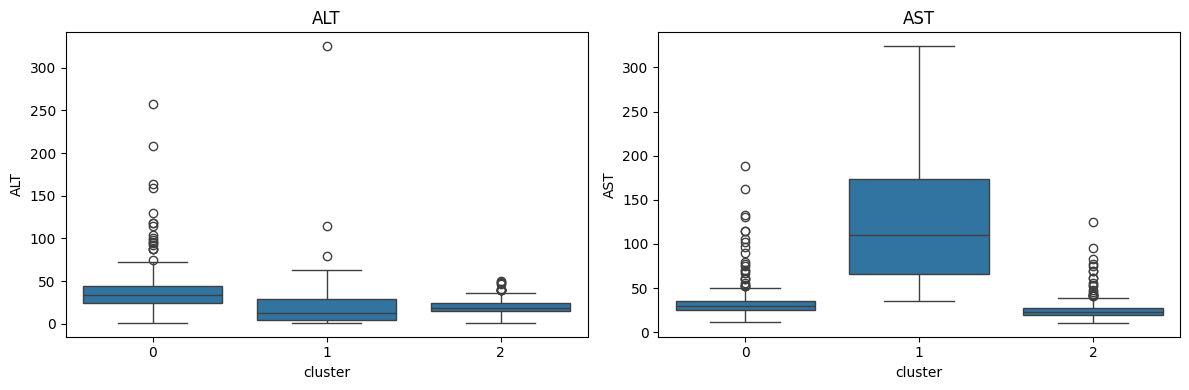

In [41]:
# 20) Boxplots (selected features)
features_plot = existing if 'existing' in globals() and len(existing)>0 else df_wins.columns[:3].tolist()
plt.figure(figsize=(12,4))
for i, col in enumerate(features_plot,1):
    plt.subplot(1, len(features_plot), i)
    sns.boxplot(x=df_out['cluster'], y=df_out[col])
    plt.title(col)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'boxplots_by_cluster.png'), dpi=200)
plt.show()

## 21) Save quick textual summary
Save a short analysis_summary.txt summarizing chosen k, silhouette, cluster sizes and list saved files.

In [42]:
# 21) Save summary text file
with open(os.path.join(OUT_DIR, 'analysis_summary.txt'), 'w') as f:
    f.write('Hepatitis C Data Analysis\n')
    f.write(f'Chosen k: {k_opt}\n')
    f.write(f'Silhouette score: {round(sil_score,4)}\n')
    f.write('Cluster sizes:\n')
    for i in range(k_opt):
        f.write(f'  Cluster {i}: {int((cluster_labels==i).sum())}\n')
    f.write('\nSaved files in this folder:\n')
    for fname in sorted(os.listdir(OUT_DIR)):
        f.write('  ' + fname + '\n')

print('Saved analysis_summary.txt and listed files:')
print('\n'.join(sorted(os.listdir(OUT_DIR))))

Saved analysis_summary.txt and listed files:
analysis_summary.txt
boxplots_by_cluster.png
cluster_profile.csv
cluster_summary_selected_features.csv
data_with_clusters.csv
elbow_silhouette.png
kmeans_model.pkl
pca_clusters.png
pca_true_labels.png
scaled_features.csv
